In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import statistics
from time import time
from decimal import Decimal
from scipy.signal import find_peaks
from scipy.optimize import curve_fit

# Import training data

In [3]:
### import normal tests
tic = time()

for i in range(1, 5):
    signals_file = f"./Training/BUN_normal/ATData/{i}.xlsx"
    n_signals = f"n_signals_{i}"
    
    bubble_detect_file = f"./Training/BUN_normal/BubbleDetectTime/{i}.xlsx"
    n_bubble_detect = f"n_bubble_detect_{i}"
    
    globals()[n_signals] = pd.read_excel(signals_file)
    globals()[n_bubble_detect] = pd.read_excel(bubble_detect_file)
    
# concatenating normal tests
n_signals = pd.concat([n_signals_1, n_signals_2, n_signals_3, n_signals_4])
n_bubble_detect = pd.concat([n_bubble_detect_1, n_bubble_detect_2, n_bubble_detect_3, n_bubble_detect_4])

toc = time()
print(f"Done in {toc - tic:.3f}s")

Done in 1029.940s


In [4]:
### import TRAINING ref failures
tic = time()

rf_signals = pd.read_excel('./Training/all_fail/ref_failures_ATData.xlsx')
rf_bubble_detect = pd.read_excel('./Training/all_fail/ref_failures_BubbleDetectTime.xlsx')

toc = time()
print(f"Done in {toc - tic:.3f}s")

Done in 447.199s


In [5]:
### import TRAINING LT ref bubbles
tic = time()

rb_signals = pd.read_excel('./Training/all_bubbles/ref_bubbles_ATData.xlsx')
rb_bubble_detect = pd.read_excel('./Training/all_bubbles/ref_bubbles_BubbleDetectTime.xlsx')

toc = time()
print(f"Done in {toc - tic:.3f}s")

Done in 22.078s


# Create test objects and dataframe

In [6]:
class Test:
    def __init__(self, ID, BubbleDetectTime, P4, P5, A4):
        self.ID = ID
        self.BubbleDetectTime = BubbleDetectTime
        self.P4 = P4 # potassium
        self.P5 = P5 # calcium
        self.A4 = A4 # crea
        
    # function to offset t = 0
    def offset_time(self):
        # using Decimal due to rounding error
        t_0 = Decimal(str(self.BubbleDetectTime + 30))
        t_step = Decimal(str(0.2))
        start_idx = round(t_0/t_step) - 1
                
        self.P4 = self.P4[start_idx:]
        self.P5 = self.P5[start_idx:]
        self.A4 = self.A4[start_idx:]
        
    # function to trim NaNs
    def trim_NaNs(self):
        # making sure list is not empty
        while len(self.P4) > 0 and math.isnan(self.P4[-1]):
            self.P4.pop()
                
        while len(self.P5) > 0 and math.isnan(self.P5[-1]):
            self.P5.pop()
        
        while len(self.A4) > 0 and math.isnan(self.A4[-1]):
            self.A4.pop()
            

def create_test_list(signals, bubble_detect_time):
    # separating channels
    group_channels = signals.groupby('Channel')
    channel_dfs = {}

    # iterating over the groups and creating a new dataframe for each group
    for channel, group in group_channels:
        df = pd.DataFrame(group.iloc[:, 2:])
        channel_dfs[channel] = df

    # creating test objects
    tests = []
    for i in range(0, len(bubble_detect_time)):
        ID = bubble_detect_time.iloc[i, 0]
        BubbleDetectTime = bubble_detect_time.iloc[i, 1]
        P4 = channel_dfs['P4'].iloc[i, :].values.tolist()
        P5 = channel_dfs['P5'].iloc[i, :].values.tolist()
        A4 = channel_dfs['A4'].iloc[i, :].values.tolist()

        new_test = Test(ID, BubbleDetectTime, P4, P5, A4)
        tests.append(new_test)
    
    return tests

In [7]:
### making test objects for each test type
labels = ["Normal", "Ref failure", "Ref bubble"]
signals = [n_signals, rf_signals, rb_signals]
bubble_detect_times = [n_bubble_detect, rf_bubble_detect, rb_bubble_detect]

test_dict = {}

for label, signal, bubble_detect_time in zip(labels, signals, bubble_detect_times):
    test_dict[label] = create_test_list(signal, bubble_detect_time)

### offset and trim all tests
for test_type in test_dict.values():
    for idx, test in enumerate(test_type): 
        test.offset_time()
        test.trim_NaNs()
        
n_tests = test_dict["Normal"]
rf_tests = test_dict["Ref failure"]
rb_tests = test_dict["Ref bubble"]

In [8]:
print(len(n_tests))
print(len(rf_tests))
print(len(rb_tests))

6922
2706
201


# Filtering for pipeline condition

In [9]:
def flag_peaks(tests):
    test_peaks = []

    for test in tests:
        # captures ref failures at end of signal
        # note: width=(100, 1400) also optimizes accuracy with 99.4% and 98.5%
        peaks, properties = find_peaks(-1*np.array(test.P4), width=10) 

        # """"
        if len(peaks) == 0:
            # check for ref failure at start of signal
            peaks, _ = find_peaks(np.array(test.P4), width=10) 
        # """

        test_peaks.append(peaks)
        
    return test_peaks

In [10]:
# finding peaks in normal and ref failures
labels = ['Normal', 'Ref failure']
tests = {'Normal': n_tests, 'Ref failure': rf_tests} # dict of test objects
peaks = {'Normal': flag_peaks(n_tests), 'Ref failure': flag_peaks(rf_tests)} # dict of peaks found in each test
targets = {'Normal': [], 'Ref failure': []} # dict of tests that are accepted under pipeline condition

# filtering
for label in labels:
    for idx, peak_list in enumerate(peaks[label]):
        if (0 < len(peak_list) <= 5):
            targets[label].append(tests[label][idx]) # append test object not idx
        
print(len(targets['Normal']))
print(len(targets['Ref failure']))

for label in labels:
    tests[label] = [test for test in tests[label] if test in targets[label]]
    
print(len(tests['Normal']))
print(len(tests['Ref failure']))

1334
2660
1334
2660


In [11]:
### labelling tests

# creating new dataframes with class for each test - note: this makes the value type np.int32
n_df = pd.DataFrame({'Test': tests['Normal'], 'Class': np.repeat(0, len(tests['Normal'])), 'Predicted': ''})
rf_df = pd.DataFrame({'Test': tests['Ref failure'], 'Class': np.repeat(1, len(tests['Ref failure'])), 'Predicted': ''})
# rb_df = pd.DataFrame({'Test': rb_tests, 'Class': np.repeat(2, len(rb_tests))})

# concatenating
test_df = pd.concat([n_df, rf_df]).reset_index(drop=True)

# list of tests that have no data after offsetting and removing NaNs (i.e. too short)
short_tests = [9948792,9948793,9948801,10053185,10616713]

# list of all TestIDs that were mislabelled BINARY N/RF ONLY
mislabelled_IDs = [9938538,10156680,9925364,9925365,9925366,9925372,9930007,9936122,9938269,9938374,9940434,9940579,9948565,
                   9948808,9976467,9979141,9990178,9990296,9938596,9987550,10016424,10017306,10017317,10018494,10018535,10018609,
                   10019934,10020102,10020118,10032447,10037336,10037557,10045983,10050257,10052220,10053192,10053197,10055126,
                   10055522,10092143,10093215,10093219,10093244,10099978,10099988,10141397,10141399,10144297,10156758,10161679,
                   10161848,10162232,10209158,10209160,10209340,10209347,10209351,10209615,10210158,10210166,10212789,10212816,
                   10216677,10216792,10216948,10217218,10217373,10222336,10222367,10230372,10230503,10230647,10230736,10230861,
                   10231582,10235570,10300110,10300128,10300436,10303517,10324466,10324863,10326050,10326154,10331129,10331645,
                   10331649,10331655,10331682,10351954,10352005,10353310,10353757,10353844,10366986,10367003,10367312,10367314,
                   10368483,10368573,10368599,10371167,10393545,10393678,10393679,10393684,10393688,10398049,10399520,10399548,
                   10399592,10399603,10399606,10444796,10444826,10444850,10445377,10445390,10445467,10447550,10447578,10450845,
                   10473452,10473483,10473498,10474543,10474550,10474802,10477552,10477668,10477673,10477844,10477883,10477893,
                   10479485,10479621,10516528,10516801,10517397,10517537,10521862,10521874,10522228,10522324,10538397,10539869,
                   10540000,10540011,10543357,10543456,10545373,10566923,10566988,10570600,10572212,10572235,10572578,10572595,
                   10612613,10612786,10616681,10617184,10619471,10619563,10084427,10318971,10345699,10156868,10318959,10345692,
                   10637720,10639340,10639356,10639375,10658664,10658673,10658679,10658695,10658707,10661264,10661379,10679756,
                   10682362,10682367,10682785,10730144,10731308,10744370,10744443,10744533,10744534,10751336,10766517]

# rb = 9925278, 9976872, 10017313, 10017528, 10413109, 10834433 NOT ADDED!!!
# rb_n = [9976872,10017528,10413109,10834433]
# rb_rf = [10017313]

print(len(test_df))

### cleaning up
for test in test_df['Test']:
    # removing short tests
    if test.ID in short_tests:
        mask = test_df['Test'] == test
        test_df.drop(index=test_df[mask].index, inplace=True)
        test_df.reset_index(drop=True, inplace=True)
        
    # relabelling mislabelled tests
    if test.ID in mislabelled_IDs:
        mask = test_df['Test'] == test
        test_df.loc[mask, 'Class'] = abs(1 - test_df.loc[mask, 'Class'])
        
    """# fixing normal tests labelled as ref bubbles
    if test.ID in rb_n:
        mask = test_df['Test'] == test
        test_df.loc[mask, 'Class'] = 0
        
    # fixing ref failures labelled as ref bubbles
    if test.ID in rb_rf:
        mask = test_df['Test'] == test
        test_df.loc[mask, 'Class'] = 1"""
        
print(len(test_df))

3994
3994


In [11]:
print(len(test_df[test_df['Class'] == 0]))
print(len(test_df[test_df['Class'] == 1]))

1174
2820


# Function fitting functions - BULK TESTS

In [12]:
# define the polynomial function to fit
def poly_func(x, a, b, c, d, e, f):
    return a*x**5 + b*x**4 + c*x**3 + d*x**2 + e*x + f


# fit error to polynomial curve
def fit_poly(idx, tests):
    y = tests[idx].P4

    start_time = 0.2
    end_time = 0.2*len(y)
    num_steps = round((end_time - start_time)/0.2) + 1

    x = np.linspace(start_time, end_time, num_steps)

    # perform the curve fit
    popt, _ = curve_fit(poly_func, x, y)
    y_fit = poly_func(x, *popt) # unpacks tuple into the 6 coefficients rather than passing an array

    return x, y, y_fit, popt # ADDED POPT TO SEE COEFFICIENTS
    
    
def compute_residuals(y, y_fit):
    residuals = y - y_fit
    
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    r_squared = 1 - (ss_res / ss_tot)
        
    return r_squared

# Function fitting functions - SINGLE TEST (for predictions)

In [12]:
# define the polynomial function to fit
def poly_func(x, a, b, c, d, e, f):
    return a*x**5 + b*x**4 + c*x**3 + d*x**2 + e*x + f


# fit data to polynomial curve for one test
def fit_poly(test):
    y = test.P4

    start_time = 0.2
    end_time = 0.2*len(y)
    num_steps = round((end_time - start_time)/0.2) + 1

    x = np.linspace(start_time, end_time, num_steps)

    # perform the curve fit
    popt, _ = curve_fit(poly_func, x, y)
    y_fit = poly_func(x, *popt) # unpacks tuple into the 6 coefficients rather than passing an array

    return x, y, y_fit, popt


def compute_residuals(y, y_fit):
    residuals = y - y_fit
    
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    r_squared = 1 - (ss_res / ss_tot)
        
    return r_squared

# Getting all R-squared values

In [16]:
### fitting normal tests to polynomial/linear functions
x_list = {'Normal': [], 'Ref failure': []}
y_list = {'Normal': [], 'Ref failure': []}
y_fit_list = {'Normal': [], 'Ref failure': []}
coef_list = {'Normal': [], 'Ref failure': []}

# extracting all test objects to list
# why am i making a joint test_df just to split them up again? idk
tests['Normal'] = test_df[test_df['Class'] == 0]['Test'].to_list() 
tests['Ref failure'] = test_df[test_df['Class'] == 1]['Test'].to_list() 

for label in labels:
    for idx, _ in enumerate(tests[label]):
        x, y, y_fit, coef = fit_poly(idx, tests[label])
        x_list[label].append(x)
        y_list[label].append(y)
        y_fit_list[label].append(y_fit)
        coef_list[label].append(coef)
    
### computing R-squared values to evaluate fit
rs_list = {'Normal': [], 'Ref failure': []}

for label in labels:
    for y, y_fit in zip(y_list[label], y_fit_list[label]):
        rs_list[label].append(compute_residuals(y, y_fit))
    
    rs_list[label].sort()

In [34]:
"""for r_squared in rs_list['Normal']:
    print(f"R-squared: {r_squared:.4f}")"""

R-squared: 0.7521
R-squared: 0.9777
R-squared: 0.9813
R-squared: 0.9836
R-squared: 0.9892
R-squared: 0.9898
R-squared: 0.9910
R-squared: 0.9910
R-squared: 0.9910
R-squared: 0.9921
R-squared: 0.9924
R-squared: 0.9924
R-squared: 0.9933
R-squared: 0.9942
R-squared: 0.9945
R-squared: 0.9948
R-squared: 0.9949
R-squared: 0.9956
R-squared: 0.9957
R-squared: 0.9957
R-squared: 0.9957
R-squared: 0.9958
R-squared: 0.9959
R-squared: 0.9960
R-squared: 0.9964
R-squared: 0.9967
R-squared: 0.9971
R-squared: 0.9972
R-squared: 0.9972
R-squared: 0.9973
R-squared: 0.9975
R-squared: 0.9975
R-squared: 0.9976
R-squared: 0.9978
R-squared: 0.9982
R-squared: 0.9982
R-squared: 0.9983
R-squared: 0.9983
R-squared: 0.9983
R-squared: 0.9984
R-squared: 0.9985
R-squared: 0.9985
R-squared: 0.9985
R-squared: 0.9985
R-squared: 0.9986
R-squared: 0.9986
R-squared: 0.9987
R-squared: 0.9987
R-squared: 0.9988
R-squared: 0.9988
R-squared: 0.9988
R-squared: 0.9988
R-squared: 0.9988
R-squared: 0.9988
R-squared: 0.9988
R-squared:

In [18]:
import csv

csv_file_path = 'rsquared_distributions.csv'

# find the maximum number of values for any key in the dictionary
max_values = max(len(values) for values in rs_list.values())

# fill in missing values with an empty string
for key in rs_list.keys():
    rs_list[key] += [0] * (max_values - len(rs_list[key]))

with open(csv_file_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    
    # Write the column headers
    writer.writerow(rs_list.keys())
    
    # Write the data rows
    writer.writerows(zip(*rs_list.values()))

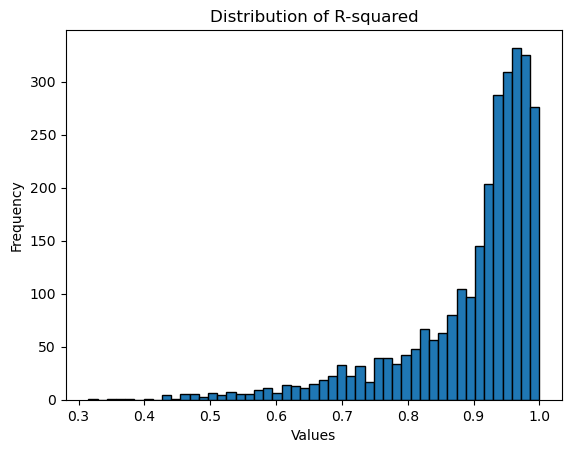

In [15]:
# plotting distribution of R-squared
plt.hist(rs_list['Ref failure'], bins='auto', edgecolor='black')
# plt.hist(rs_list['Ref failure'], bins='auto', edgecolor='black')

# add labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Distribution of R-squared')

# show the plot
plt.show()

# Skip following two blocks

In [14]:
# calculating medians and MADS
n_median = np.median(rs_list['Normal'])
rf_median = np.median(rs_list['Ref failure'])

# only used for visualizing distribution
# n_MAD = np.median(np.abs(rs_list['Normal'] - n_median))
# rf_MAD = np.median(np.abs(rs_list['Ref failure'] - rf_median))

print(n_median)
print(rf_median)

0.999935591802982
0.9366971128020606


In [50]:
"""
- the original threshold was 0.9975 because it seems to maximize ref failure TP before a significant dropoff in normal TP
- but if we are introducing a region of ambiguity, is there a threshold that will allow for the same proportion of correct 
classifications while minimizing the number of tests that cannot be confidently classified?
"""

test_threshold = [0.9940, 0.9945, 0.9950, 0.9955, 0.9960, 0.9965, 0.9970, 0.9975, 0.9980, 0.9985, 0.9990]
results = {'Normal': [], 'Ref failure': []}
bounds = {'Normal': [], 'Ref failure': []} # lower bound for normal, upper bound for ref failure

for threshold in test_threshold:
    # normal
    n_dist_med = []
    for rs in rs_list['Normal']:
        if rs <= threshold:
            n_dist_med.append(n_median - rs)
            
    median_n_dist_med = np.median(n_dist_med)
    results['Normal'].append(median_n_dist_med)
    bounds['Normal'].append(n_median - median_n_dist_med)
    
    # ref failure
    rf_dist_med = []
    for rs in rs_list['Ref failure']:
        if rs > threshold:
            rf_dist_med.append(rs - rf_median)
            
    median_rf_dist_med = np.median(rf_dist_med)
    results['Ref failure'].append(median_rf_dist_med)
    bounds['Ref failure'].append(rf_median + median_rf_dist_med)
    
for lower, upper in zip(bounds['Normal'], bounds['Ref failure']):
    print(f"Range = [{lower:.6f}, {upper:.6f}], width = {(upper - lower):.6f}")

Range = [0.990981, 0.998198], width = 0.007217
Range = [0.991040, 0.998408], width = 0.007367
Range = [0.991045, 0.998506], width = 0.007461
Range = [0.991045, 0.998597], width = 0.007552
Range = [0.992815, 0.998715], width = 0.005901
Range = [0.993268, 0.998753], width = 0.005485
Range = [0.993752, 0.999218], width = 0.005466
Range = [0.994845, 0.999286], width = 0.004442
Range = [0.995278, 0.999475], width = 0.004198
Range = [0.995744, 0.999579], width = 0.003835
Range = [0.998326, 0.999724], width = 0.001398


# Predictions and evaluation

In [13]:
"""
- tempted to take the range with the smallest width, but the second smallest width actually contains the original threshold,
so i'm hoping the classification accuracy would be similar but i will compare both
"""
# lists to store R-squared values that fall in ambiguous region
n_ambiguous = []
rf_ambiguous = []

# upper and lower bounds from above
upper = 0.999218
lower = 0.993752

for idx, test in enumerate(test_df['Test']):
    # fit to polynomial function
    x, y, y_fit, popt = fit_poly(test)

    # compute R-squared value
    r_squared = compute_residuals(y, y_fit)
    
    # hard threshold
    if r_squared > 0.9975:
        test_df.loc[idx, 'Predicted'] = 0 # normal
    else:
        test_df.loc[idx, 'Predicted'] = 1 # ref failure
    
    # soft threshold?
    """if r_squared > upper: 
        test_df.loc[idx, 'Predicted'] = 0 # normal
        # print(f"Class: {test_df.loc[idx, 'Class']}, R-squared: {r_squared}, Predicted: 0")
    elif r_squared < lower: 
        test_df.loc[idx, 'Predicted'] = 1 # ref failure
        # print(f"Class: {test_df.loc[idx, 'Class']}, R-squared: {r_squared}, Predicted: 1")
    else: # in between
        test_df.loc[idx, 'Predicted'] = -1 # ambiguous
        
        if test_df.loc[idx, 'Class'] == 0:
            n_ambiguous.append(r_squared)
        elif test_df.loc[idx, 'Class'] == 1:
            rf_ambiguous.append(r_squared)"""
            
        # print(f"Class: {test_df.loc[idx, 'Class']}, R-squared: {r_squared:.4f}, Predicted: -1")
        
test_df['Predicted'] = test_df['Predicted'].astype(np.int32)

print(len(n_ambiguous))
print(len(rf_ambiguous))

0
0


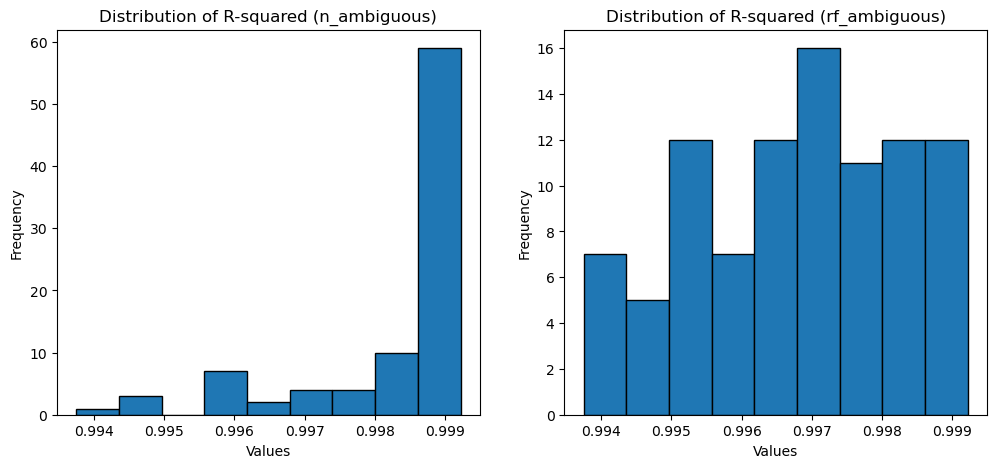

In [43]:
# plotting distribution of ambiguous R-squared
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

edges = np.linspace(lower, upper, 10)

axs[0].hist(n_ambiguous, bins=edges, edgecolor='black')
axs[1].hist(rf_ambiguous, bins=edges, edgecolor='black')

# normal
axs[0].set_xlabel('Values')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Distribution of R-squared (n_ambiguous)')

# ref failure
axs[1].set_xlabel('Values')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Distribution of R-squared (rf_ambiguous)')

# show the plot
plt.show()

In [18]:
# removing ambiguous tests to calculate accuracy of non-ambiguous tests
print(len(test_df))

mask = test_df['Predicted'] == -1
test_df.drop(index=test_df[mask].index, inplace=True)
test_df.reset_index(drop=True, inplace=True)

print(len(test_df))

3994
3813


In [42]:
from sklearn.metrics import confusion_matrix, classification_report
CM = confusion_matrix(test_df['Class'], test_df['Predicted'])

print("Confusion Matrix\n")
print(CM)
print('\n')

print("Classification Report\n")
print(classification_report(test_df['Class'], test_df['Predicted'], target_names=labels))

Confusion Matrix

[[1143   31]
 [  80 2740]]


Classification Report

              precision    recall  f1-score   support

      Normal       0.93      0.97      0.95      1174
 Ref failure       0.99      0.97      0.98      2820

    accuracy                           0.97      3994
   macro avg       0.96      0.97      0.97      3994
weighted avg       0.97      0.97      0.97      3994



In [38]:
"""# Function to print a formatted table cell
def print_cell(content, width):
    print(f"| {content:^{width}}", end="")

# Function to print a row separator
def print_separator(width, num_columns):
    print("|" + "-" * (width + 2) * num_columns + "|")

# Define labels
labels = ["Normal", "Ref failure"]  # Replace with your actual class labels

# Printing confusion matrix
cell_width = 12
print("Confusion Matrix:")
print_separator(cell_width, 3)
print_cell("", cell_width+1)
print_cell("Actual (+)", cell_width)
print_cell("Actual (-)", cell_width)
print("|")
print_separator(cell_width, 3)
print_cell("Predicted (+)", cell_width)
print_cell(tp, cell_width)
print_cell(fp, cell_width)
print("|")
print_separator(cell_width, 3)
print_cell("Predicted (-)", cell_width)
print_cell(fn, cell_width)
print_cell(tn, cell_width)
print("|")
print_separator(cell_width, 3)

# Classification report
print("\nClassification Report:")
print(classification_report(test_df['Class'], test_df['Predicted'], target_names=labels))"""

Confusion Matrix:
|------------------------------------------|
|              |  Actual (+) |  Actual (-) |
|------------------------------------------|
| Predicted (+)|     2740    |      31     |
|------------------------------------------|
| Predicted (-)|      80     |     1143    |
|------------------------------------------|

Classification Report:
              precision    recall  f1-score   support

      Normal       0.93      0.97      0.95      1174
 Ref failure       0.99      0.97      0.98      2820

    accuracy                           0.97      3994
   macro avg       0.96      0.97      0.97      3994
weighted avg       0.97      0.97      0.97      3994



# Temporary

In [43]:
def flag_peaks(tests):
    test_peaks = []

    for test in tests:
        # captures ref failures at end of signal
        # note: width=(100, 1400) also optimizes accuracy with 99.4% and 98.5%
        peaks, _ = find_peaks(-1*np.array(test.P4), width=100)
        
        #""""
        if len(peaks) == 0:
            # check for ref failure at start of signal
            peaks, _ = find_peaks(np.array(test.P4), width=100) 
        # """
        
        # peaks = np.concatenate((peaks_1, peaks_2)) # this might be wrong??? why is it a tuple. but if you look at the plots all the peaks are found

        test_peaks.append(peaks)
        
    return test_peaks

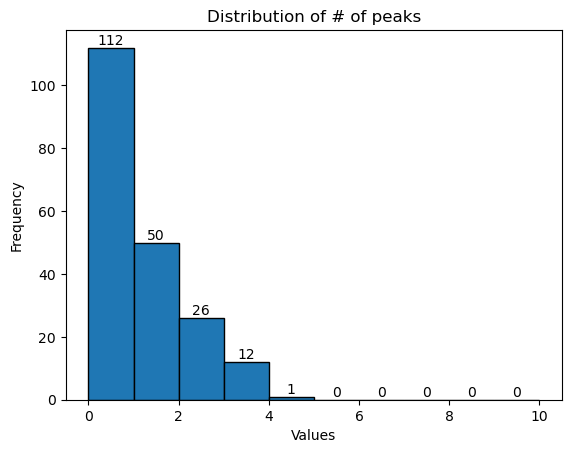

In [44]:
### finding peaks in normal tests
rb_peaks = flag_peaks(rb_tests)

# checking distribution of # of peaks
len_peaks = [len(peaks) for peaks in rb_peaks]

bin_edges = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# plotting distribution of std
counts, edges, bars = plt.hist(len_peaks, bins=bin_edges, edgecolor='black')

# add labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.bar_label(bars)
plt.title('Distribution of # of peaks')

# show the plot
plt.show()